In [2]:
import pyreadr
import pandas as pd

# 读取 .rda 文件
result = pyreadr.read_r('F://Desktop/genomics_AML_ALL_study/leukemia_data_Golub99_3051.rda')

# 查看里面的对象名
print(result.keys())

odict_keys(['golub_train_3051', 'golub_train_response', 'golub_test_3051', 'golub_test_response'])


### 导出成csv

In [3]:
train_X = result['golub_train_3051']
train_y = result['golub_train_response']
test_X = result['golub_test_3051']
test_y = result['golub_test_response']

# 保存到文件
train_X.to_csv('golub_train_X.csv', index=False)
train_y.to_csv('golub_train_y.csv', index=False)
test_X.to_csv('golub_test_X.csv', index=False)
test_y.to_csv('golub_test_y.csv', index=False)

print(train_X.shape, test_X.shape)

(38, 3051) (34, 3051)


训练集形状: (38, 3050)
测试集形状: (34, 3050)

训练集标签分布:
golub_train_response
0    27
1    11
Name: count, dtype: int64


C:\Users\chenmiaoying\AppData\Local\Temp\ipykernel_22292\428333504.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_y = train_y.replace({'ALL': 0, 'AML': 1}).astype(int)
C:\Users\chenmiaoying\AppData\Local\Temp\ipykernel_22292\428333504.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_y = test_y.replace({'ALL': 0, 'AML': 1}).astype(int)


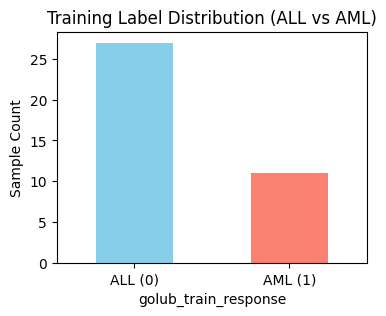

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
train_X = pd.read_csv('golub_train_X.csv', index_col=0)
test_X = pd.read_csv('golub_test_X.csv', index_col=0)

# 读取标签列（保留表头，不设 index_col）
train_y = pd.read_csv('golub_train_y.csv')["golub_train_response"]
test_y = pd.read_csv('golub_test_y.csv')["golub_test_response"]

# 转换标签为数值：ALL → 0, AML → 1
train_y = train_y.replace({'ALL': 0, 'AML': 1}).astype(int)
test_y = test_y.replace({'ALL': 0, 'AML': 1}).astype(int)

# 打印基础信息
print(f"训练集形状: {train_X.shape}")
print(f"测试集形状: {test_X.shape}")
print("\n训练集标签分布:")
print(train_y.value_counts())

# 绘制标签分布条形图
plt.figure(figsize=(4, 3))
train_y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['ALL (0)', 'AML (1)'], rotation=0)
plt.title("Training Label Distribution (ALL vs AML)")
plt.ylabel("Sample Count")
plt.show()


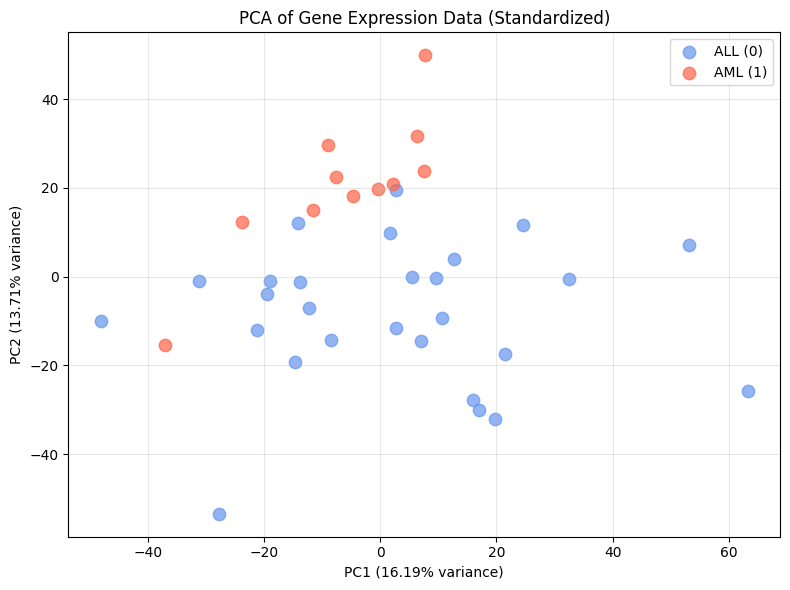

各主成分解释的方差比例： [0.1618682  0.13708011]


In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 读取数据
train_X = pd.read_csv("golub_train_X.csv")
train_y = pd.read_csv("golub_train_y.csv")

# 2. 清洗标签
train_y = train_y.iloc[:, 0].dropna().astype(str).str.strip()
y = train_y.map({'ALL': 0, 'AML': 1}).values

# 3. 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_X)

# 4. PCA 降维
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 5. 绘图
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], color='cornflowerblue', label='ALL (0)', alpha=0.7, s=80)
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], color='tomato', label='AML (1)', alpha=0.7, s=80)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('PCA of Gene Expression Data (Standardized)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("各主成分解释的方差比例：", pca.explained_variance_ratio_)


训练集形状: (38, 3051)
测试集形状: (34, 3051)

训练集标签分布:
golub_train_response
ALL    27
AML    11
Name: count, dtype: int64

混淆矩阵：
 [[19  1]
 [ 0 14]]

分类报告：
               precision    recall  f1-score   support

         ALL       1.00      0.95      0.97        20
         AML       0.93      1.00      0.97        14

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



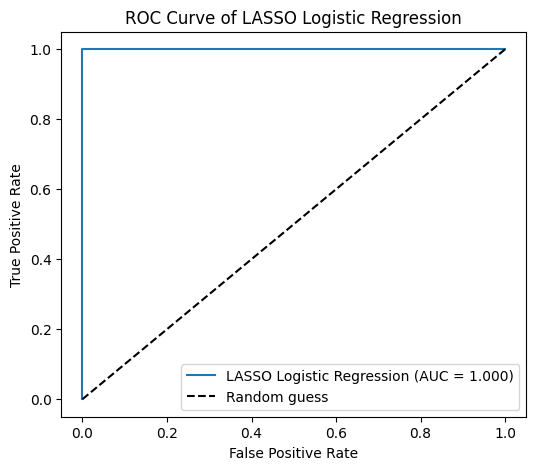

In [35]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 加载数据
train_X = pd.read_csv("golub_train_X.csv")
train_y = pd.read_csv("golub_train_y.csv").squeeze("columns")
test_X = pd.read_csv("golub_test_X.csv")
test_y = pd.read_csv("golub_test_y.csv").squeeze("columns")

print("训练集形状:", train_X.shape)
print("测试集形状:", test_X.shape)
print("\n训练集标签分布:")
print(train_y.value_counts())

# （ALL / AML → 0 / 1）
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_y)
y_test_encoded = le.transform(test_y)


# Step 3. 训练 LASSO Logistic Regression 模型
lasso_model = LogisticRegression(
    penalty='l1',        # L1正则化
    solver='liblinear',  # 适合L1小样本
    random_state=42
)

lasso_model.fit(train_X, y_train_encoded)  


# Step 4. 模型预测与性能验证
y_pred = lasso_model.predict(test_X)
y_pred_prob = lasso_model.predict_proba(test_X)[:, 1]

print("\n混淆矩阵：\n", confusion_matrix(y_test_encoded, y_pred))
print("\n分类报告：\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))


# Step 5. ROC曲线分析
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob)
auc_value = roc_auc_score(y_test_encoded, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"LASSO Logistic Regression (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of LASSO Logistic Regression")
plt.legend()
plt.show()


In [36]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    LogisticRegression(penalty='l1', solver='liblinear'),
    train_X, y_train_encoded,
    cv=cv, scoring='roc_auc'
)
print("5-fold CV AUC 平均值:", cv_scores.mean())
print("各折AUC:", cv_scores)

5-fold CV AUC 平均值: 0.9400000000000001
各折AUC: [0.83333333 1.         0.86666667 1.         1.        ]


共选择了 23 个非零特征
M27891_at           0.918342
X95735_at           0.392496
Y12670_at           0.336099
M23197_at           0.331304
M83652_s_at         0.265260
M27783_s_at         0.227141
D26308_at           0.184118
X85116_rna1_s_at    0.174267
S81439_at           0.092135
Y00339_s_at         0.085044
dtype: float64


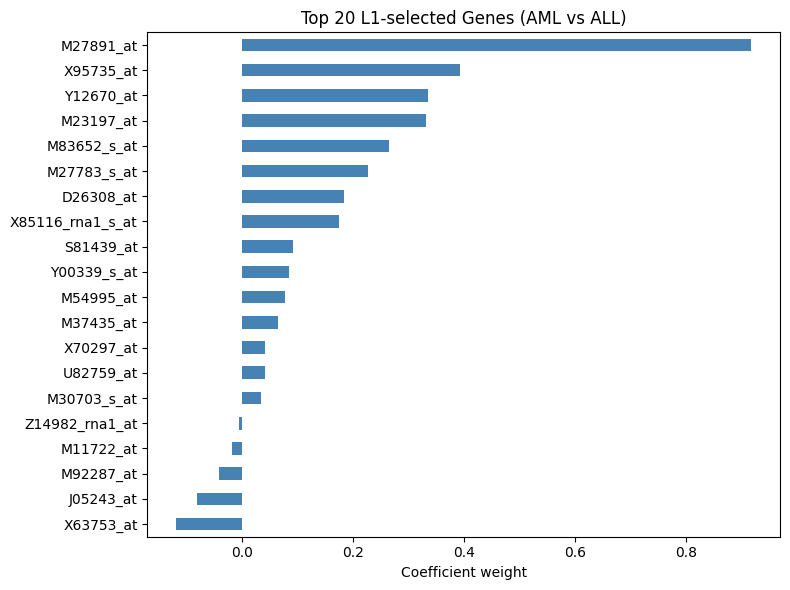

In [37]:
# 取出模型的L1系数
coef = pd.Series(lasso_model.coef_[0], index=train_X.columns)

# 仅保留非零特征
nonzero_coef = coef[coef != 0].sort_values(ascending=False)
print(f"共选择了 {len(nonzero_coef)} 个非零特征")
print(nonzero_coef.head(10))

# 前20个重要特征可视化
plt.figure(figsize=(8,6))
nonzero_coef.head(20).sort_values().plot(kind='barh', color='steelblue')
plt.title("Top 20 L1-selected Genes (AML vs ALL)")
plt.xlabel("Coefficient weight")
plt.tight_layout()
plt.show()


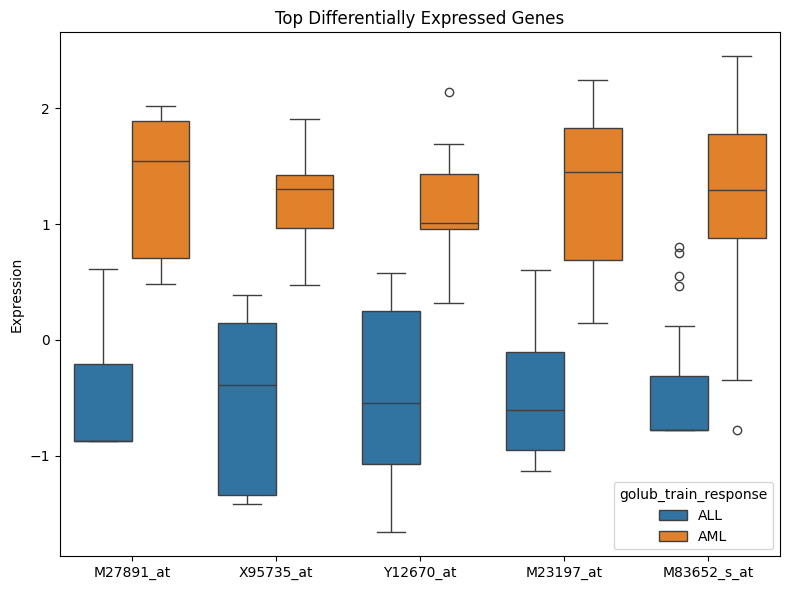

In [38]:
# 挑几个重要基因看看表达差异
top_genes = nonzero_coef.head(5).index
plot_df = pd.concat([train_X[top_genes], train_y.reset_index(drop=True)], axis=1)
plot_df = plot_df.melt(id_vars='golub_train_response', var_name='Gene', value_name='Expression')

plt.figure(figsize=(8,6))
sns.boxplot(data=plot_df, x='Gene', y='Expression', hue='golub_train_response')
plt.title("Top Differentially Expressed Genes")
plt.xlabel("")
plt.tight_layout()
plt.show()
